In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn import preprocessing
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_predict
from math import sqrt

#read data
data=pd.read_csv('cyberplant.csv')
data.head(10)

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43
5,13.97,39.16,1016.05,84.60,470.96
6,22.10,71.29,1008.20,75.38,442.35
7,14.47,41.76,1021.98,78.41,464.00
8,31.25,69.51,1010.25,36.83,428.77
9,6.77,38.18,1017.80,81.13,484.31


In [2]:
print(data.shape)

(9568, 5)


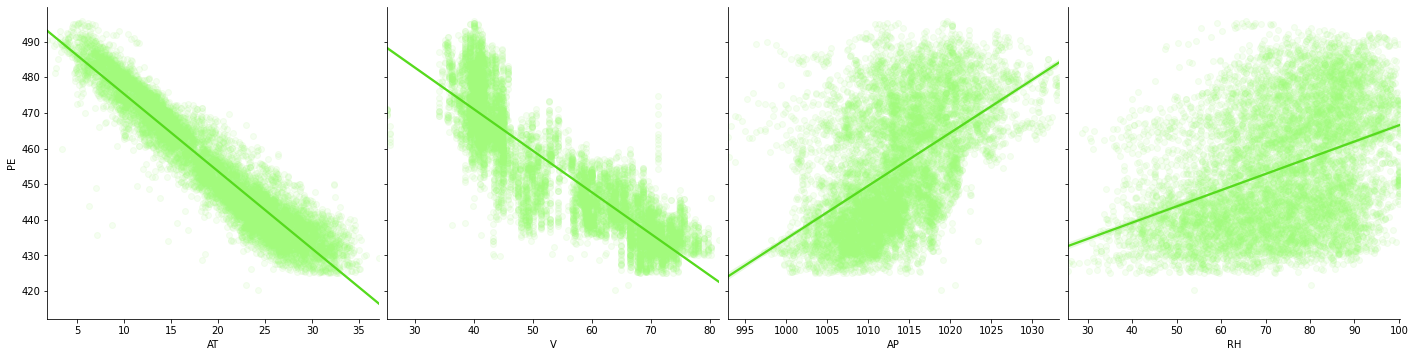

In [3]:
sns.pairplot(data,x_vars=['AT',"V","AP","RH"],y_vars='PE',height=5,kind='reg',plot_kws={'line_kws':{'color':'#56DA1D'},'scatter_kws':{'alpha':0.1,'color':'#A2FA7C'}})

In [4]:
##Filter Features by correlation
print(abs(data.corr()["PE"]))
print(abs(data.corr()["PE"][abs(data.corr()["PE"])>0.5].drop('PE')).index.tolist())

AT    0.948128
V     0.869780
AP    0.518429
RH    0.389794
PE    1.000000
Name: PE, dtype: float64
['AT', 'V', 'AP']


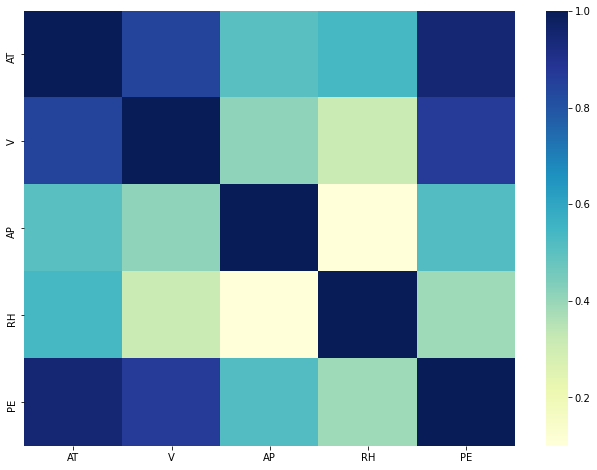

In [5]:
fig_dims=(11,8)
fig,ax=plt.subplots(figsize=fig_dims)
sns.heatmap(abs(data.corr()),ax=ax, cmap="YlGnBu")
plt.show()

In [6]:
##Filter Feature
ft=['AT',"V","AP","RH"]
X= data[ft]
y = data[['PE']]
reg=LinearRegression()
vals = [0.3,0.5,0.8,0.9]
for val in vals:
    features = abs(data.corr()["PE"][abs(data.corr()["PE"])>val].drop('PE')).index.tolist()
    X = data.drop(columns='PE')
    X = X[features]
    print(features)
    reg.fit(X,y)
    y2_pred = reg.predict(X)
    print("RMSE:%.5f"%(np.sqrt(metrics.mean_squared_error(y,y2_pred))))
    print("R_squared:%.5f"%(r2_score(y,y2_pred)))

['AT', 'V', 'AP', 'RH']
RMSE:4.55713
R_squared:0.92870
['AT', 'V', 'AP']
RMSE:4.88772
R_squared:0.91798
['AT', 'V']
RMSE:4.95419
R_squared:0.91573
['AT']
RMSE:5.42510
R_squared:0.89895


In [7]:
#define
ft=['AT',"V","AP","RH"]
X= data[ft]
y = data[['PE']]

#Split Train/Test Set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=2)

#Shape of data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6697, 4)
(6697, 1)
(2871, 4)
(2871, 1)


In [8]:
#Build Training Model
reg=LinearRegression()
reg.fit(X_train,y_train)

#print the model performance
print('intercept :' ,reg.intercept_)
print('coef :' ,reg.coef_)

#Predict the test set
y_pred = reg.predict(X_test)
print('predict:' ,y_pred[0:5])

##จะได้สมการว่า y=-1.97583665*AT -0.23588334*V  +0.0606941*AP  -0.15777302*RH +456.09483695

intercept : [456.09483695]
coef : [[-1.97583665 -0.23588334  0.0606941  -0.15777302]]
predict: [[430.5525121 ]
 [465.87666815]
 [430.5274532 ]
 [472.74257916]
 [465.13988363]]


In [9]:
##Predict by input value
#input :AT,V,AP,RH

reg.predict([[37,40,1000,68]])

array([[423.51908308]])

In [10]:
##Residual

import statsmodels.api as sm

#fit linear regression model
model = sm.OLS(y_test, y_pred).fit() 

#create instance of influence
influence = model.get_influence()

#obtain standardized residuals
standardized_residuals = influence.resid_studentized_internal

#display standardized residuals
print(standardized_residuals[0:18])

[ 0.95821634  1.15140994  0.29383648  1.48534348 -0.98375228  0.38747037
 -0.54284876  0.27518476  0.16312795  0.39613739 -0.18131184  1.57344842
  0.58277927  1.16290162 -0.78776572  1.82080581  0.68677316  0.51768135]


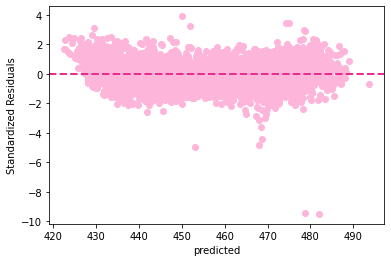

In [11]:
import matplotlib.pyplot as plt

plt.scatter(y_pred, standardized_residuals,color="#FEB5DA")
plt.xlabel('predicted')
plt.ylabel('Standardized Residuals')
plt.axhline(y=0, color='#EA2C8C', linestyle='--', linewidth=2)
plt.show()

In [12]:
#evaluate model
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
print('r2:',r2_score(y_test,y_pred))

RMSE: 4.568781919765429
r2: 0.9281426364495198


In [13]:
import statsmodels.api as sm
X1 = sm.add_constant(y_test)
result = sm.OLS(y_pred, X1).fit()
#print dir(result)
print ("adjust R2:",result.rsquared_adj)

from sklearn.metrics import r2_score   
r2_score(y_test, y_pred)   
print("adjust R2:",1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test.columns)-1)))

adjust R2: 0.9281434906570064
adjust R2: 0.9280423470377257


Text(0.5, 1.0, 'Actual vs Predicted')

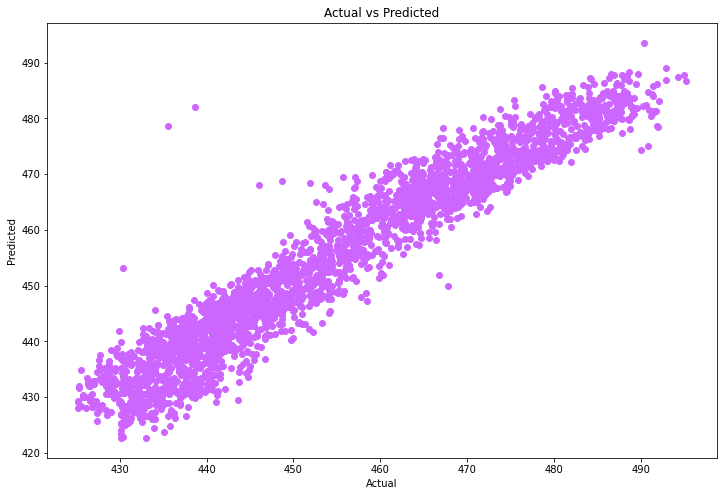

In [14]:
#Plot 4 input variables
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.scatter(y_test,y_pred,color='#CC66FF')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

<AxesSubplot:xlabel='PE'>

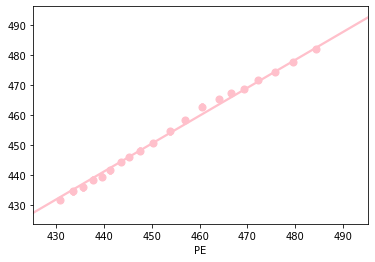

In [15]:
sns.regplot(x=y_test,y=y_pred,color='pink',x_bins=20 )

In [16]:
##Try other features
#define
fs=['AT','V','AP']
X1= data[fs]
y1 = data[['PE']]

#Split Train/Test Set
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1,test_size=0.3,random_state=0)

#Build Training Model
reg=LinearRegression()
reg.fit(X1_train,y1_train)

#print the model performance
print('intercept :' ,reg.intercept_)
print('coef :' ,reg.coef_)

#Predict the test set
y1_pred = reg.predict(X1_test)
print("Predict: " ,y1_pred[0:5])

#evaluate model
print("R2: ",r2_score(y1_test,y1_pred))
print("RMSE: ",np.sqrt(metrics.mean_squared_error(y1_test,y1_pred)))

##จะได้สมการว่า y = -1.63356736*AT -0.32872823*V  +0.16765454*AP + 334.44310511

intercept : [334.44310511]
coef : [[-1.63356736 -0.32872823  0.16765454]]
Predict:  [[434.84763586]
 [449.80976911]
 [443.01647176]
 [447.16634204]
 [460.22156405]]
R2:  0.9182926889446965
RMSE:  4.867178307347008


Text(0.5, 1.0, 'Actual vs Predicted')

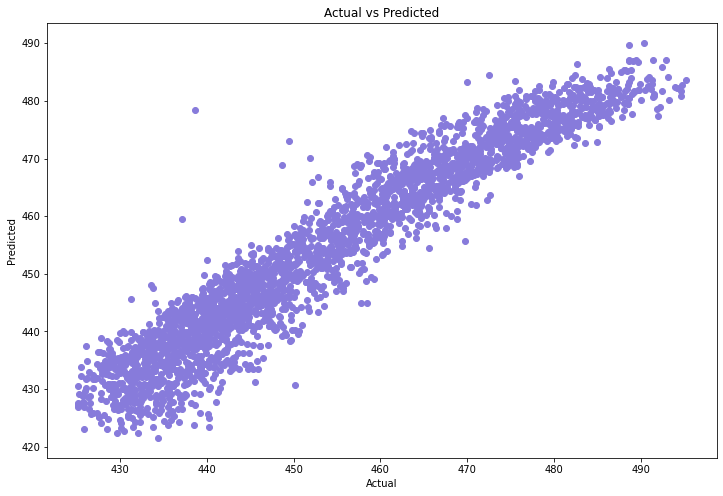

In [17]:
#Plot 3 input variables
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.scatter(y1_test,y1_pred,color='#877BDB')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

<AxesSubplot:xlabel='PE'>

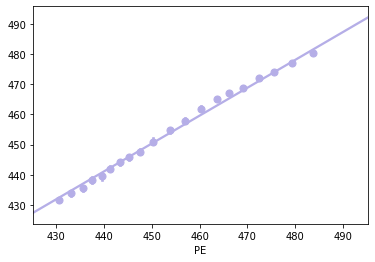

In [18]:
sns.regplot(x=y1_test,y=y1_pred,color='#B5AEE7',x_bins=20 )

In [19]:
##Try other features
#define
fp=['AT','RH']
X1= data[fp]
y1 = data[['PE']]

#Split Train/Test Set
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1,test_size=0.3,random_state=0)

#Build Training Model
reg=LinearRegression()
reg.fit(X1_train,y1_train)

#print the model performance
print('intercept :' ,reg.intercept_)
print('coef :' ,reg.coef_)

#Predict the test set
y2_pred = reg.predict(X1_test)
print("Predict: " ,y2_pred[0:5])

#evaluate model
print("R2: ",r2_score(y1_test,y2_pred))
print("RMSE: ",np.sqrt(metrics.mean_squared_error(y1_test,y2_pred)))

##จะได้สมการว่า y = -2.39607153*AT -0.20821537*RH + 516.74318951
##เห็นได้ว่าตัดออกไป2ตัว ค่าก็ไม่ต่างจาก 4ตัว

intercept : [516.74318951]
coef : [[-2.39607153 -0.20821537]]
Predict:  [[433.9193077 ]
 [447.82430899]
 [445.56827454]
 [445.45277677]
 [464.42038234]]
R2:  0.9212377281441754
RMSE:  4.778657614438388


Text(0.5, 1.0, 'Actual vs Predicted')

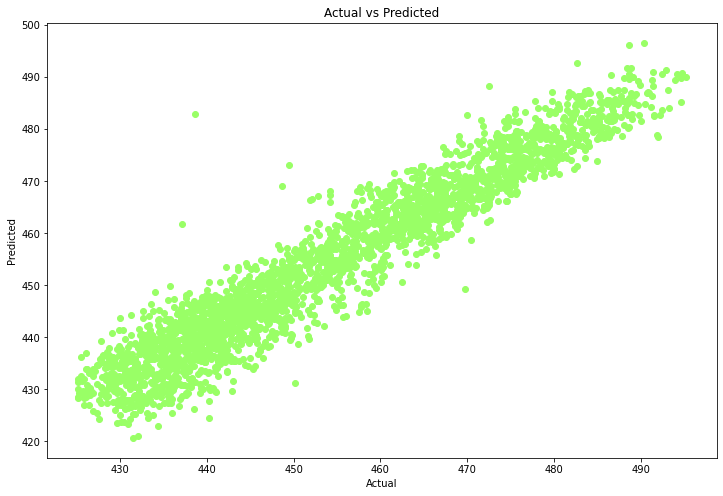

In [20]:
#Plot 2 input variables
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.scatter(y1_test,y2_pred,color='#99FF66')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

<AxesSubplot:xlabel='PE'>

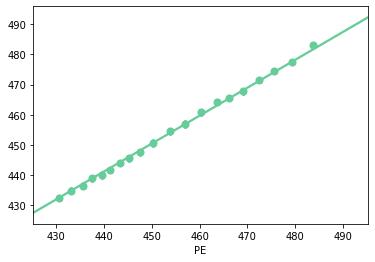

In [21]:
sns.regplot(x=y1_test,y=y2_pred,color='#66CC99',x_bins=20 )

In [22]:
##LASSO
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=0.1,precompute=True,
              selection='random',
              random_state=42)

##แบ่ง test/train size 50/50
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,random_state=1)
lasso.fit(X_train,y_train)
lasso_coef=lasso.fit(X_train,y_train).coef_
print(lasso.coef_)
print(lasso.intercept_)

[-1.97317691 -0.23352767  0.0669023  -0.15484427]
[449.41353043]


In [23]:
def print_evaluate(true, predicted):  
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    mae = metrics.mean_absolute_error(true, predicted)
    r2_square = metrics.r2_score(true, predicted)
    print('RMSE:', rmse)
    print('MAE:', mae)
    print('R Square', r2_square)
    
test_pred = lasso.predict(X_test)
print('Test set evaluation:')
print_evaluate(y_test, test_pred)

Test set evaluation:
RMSE: 4.591429159548138
MAE: 3.619757711969596
R Square 0.9279018057709192


Text(0.5, 1.0, 'Actual vs Predicted')

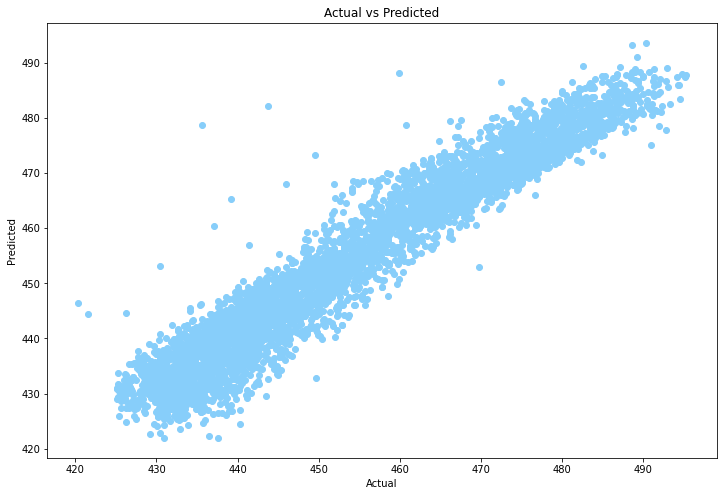

In [24]:
#Plot splits 0.5
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.scatter(y_test,test_pred,color='#87CEFA')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

<AxesSubplot:xlabel='PE'>

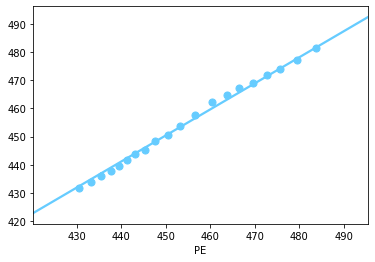

In [25]:
sns.regplot(x=y_test,y=test_pred,color='#66CCFF',x_bins=20 )

In [72]:
##Cross validation
ft=['AT',"V","AP","RH"]
X= data[ft]
y = data[['PE']]
cv = KFold(n_splits=10)
reg=LinearRegression()
reg.fit(X_train,y_train)
y_predict=cross_val_predict(reg,X,y,cv=cv)
cross=cross_val_score(reg,X,y,cv=cv)
print("RMSE: " +str(sqrt(mean_squared_error(y,y_predict))))
print("Score model: " +str(cross))

RMSE: 4.560219014690314
Score model: [0.93331112 0.92679388 0.92798623 0.90978679 0.9336586  0.92876783
 0.92906665 0.92709146 0.9330478  0.93399065]


Text(0.5, 1.0, 'Actual vs Predicted')

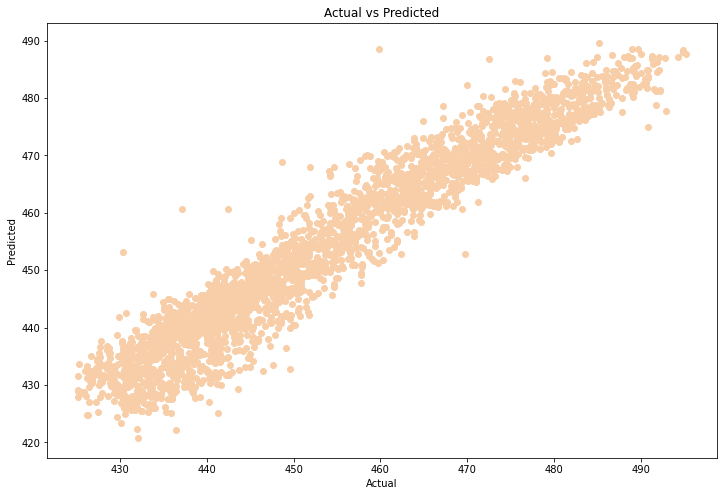

In [67]:
#Plot spilts=8
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.scatter(y_test,y_predict,color='#f7cea8')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

<AxesSubplot:xlabel='PE'>

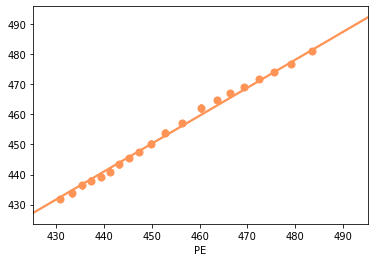

In [64]:
sns.regplot(x=y_test,y=y_predict,color='#ff9456',x_bins=20 )

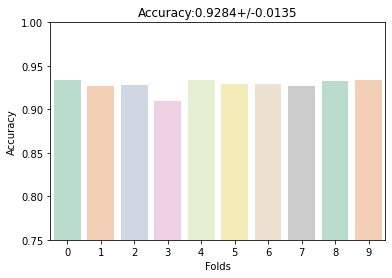

In [73]:
ax = sns.barplot(x=list(range(10)),y=cross, palette="Pastel2",dodge=True)
ax.set(xlabel="Folds",ylabel="Accuracy")
ax.set_title('Accuracy:{:0.4f}+/-{:0.4f}'.format(cross.mean(),cross.std()*2))
ax.set(ylim=(0.75, 1))
plt.show()